In [1]:
import pandas as pd
import seaborn as sns
sns.set()

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from flask import Flask
import pickle

import datetime
import calendar

# This config is set as False to print the model's default parameters when we print the model
# Without this, only the parameters which are explicitly specified will be printed, not all
from sklearn import set_config
set_config(print_changed_only=False)

In [2]:
df = pd.read_excel('dataset/flight-data.xlsx')

In [3]:
df.head(3)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


## Data clean up 

In [5]:
# Impute total stops as only one record is missing
df[df.Total_Stops.isna()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


In [6]:
temp = df[(df.Source == 'Delhi') & (df.Destination == 'Cochin') & (df.Airline == 'Air India')]
temp

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
10,Air India,1/06/2019,Delhi,Cochin,DEL → BLR → COK,09:45,23:00,13h 15m,1 stop,No info,8907
15,Air India,3/03/2019,Delhi,Cochin,DEL → AMD → BOM → COK,16:40,19:15 04 Mar,26h 35m,2 stops,No info,14011
18,Air India,12/06/2019,Delhi,Cochin,DEL → CCU → BOM → COK,20:15,19:15 13 Jun,23h,2 stops,No info,13381
61,Air India,3/04/2019,Delhi,Cochin,DEL → MAA → COK,06:05,09:25 04 Apr,27h 20m,1 stop,No info,5117
68,Air India,21/05/2019,Delhi,Cochin,DEL → BHO → BOM → COK,05:55,19:15,13h 20m,2 stops,No info,10861
...,...,...,...,...,...,...,...,...,...,...,...
10648,Air India,1/06/2019,Delhi,Cochin,DEL → CCU → BOM → COK,16:55,19:15 02 Jun,26h 20m,2 stops,No info,13801
10652,Air India,9/03/2019,Delhi,Cochin,DEL → TRV → COK,05:15,06:50 10 Mar,25h 35m,1 stop,No info,9790
10661,Air India,9/05/2019,Delhi,Cochin,DEL → BOM → COK,13:00,19:15,6h 15m,1 stop,No info,8372
10669,Air India,15/06/2019,Delhi,Cochin,DEL → BOM → COK,08:00,19:15,11h 15m,1 stop,No info,9929


In [7]:
# We can see flights from the same airline and same Source & Destination has 2 stops for duration more than 20 hours.
# So, we can put 2 as the Total_Stops
df.at[9039,'Total_Stops']=2
df.iloc[9039,:]
# Value is updated

Airline               Air India
Date_of_Journey       6/05/2019
Source                    Delhi
Destination              Cochin
Route                       NaN
Dep_Time                  09:45
Arrival_Time       09:25 07 May
Duration                23h 40m
Total_Stops                   2
Additional_Info         No info
Price                      7480
Name: 9039, dtype: object

### Clean up columns

In [8]:
# 1. Remove the date part from the 'Arrival_Time' column
# 2. Convert the 'Duration' column to a numeric
# 3. Convert 'Total_Stops' column to numeric
# 4. Define a new column to store the day of the week (refer from Date_of_Journey)
# 5. Define a new column to store the time frame of the day (morning, afternoon, evening, night) for Arrival_time column
# 6. Define a new column to store the time frame of the day (morning, afternoon, evening, night) for Dep_time column
# 7. Define a new column to store the hour for Arrival_Time
# 8. Define a new column to store the hour for Dep_Time

In [9]:
# 1. Remove the date part from the 'Arrival_Time' column
def strip_time(val):
    if ~pd.isnull(val):
        return val[:5]

    
df.Arrival_Time = df.Arrival_Time.apply(strip_time)

In [10]:
# 2. Convert the 'Duration' column to a numeric
def convert_duration_to_int(val):
    try:
        if ~pd.isnull(val):
            val = val.strip()
            splits = val.split(' ')
            hour = 0
            minute = 0
            if ~pd.isnull(splits[0]):
                hour = int(splits[0].split('h')[0])
            return hour
    except Exception as e:
        print(f'Issue while converting duration to integer value for the value {val}')
        print(f'Exception : {e}')
        return None
    

df.Duration = df.Duration.apply(convert_duration_to_int)

Issue while converting duration to integer value for the value 5m
Exception : invalid literal for int() with base 10: '5m'


In [11]:
# There is exception for one value
df[df.Duration.isna()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
6474,Air India,6/03/2019,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,16:50,16:55,NaN,2 stops,No info,17327


In [12]:
# Lets try to find similar details available in the dataset and replace this null value.
df[(df.Airline=='Air India') & (df.Source == 'Mumbai') & (df.Destination == 'Hyderabad')].Duration.mean()

5.614814814814815

In [13]:
# Replace the null value with this mean value (6)
df.at[6474,'Duration'] = 6

df.Duration = df.Duration.astype('int64')

In [14]:
df.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10,2,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7,2 stops,No info,7662


In [15]:
# 3. Convert 'Total_Stops' column to numeric
df.Total_Stops = df.Total_Stops.str.replace(' stops','')
df.Total_Stops = df.Total_Stops.str.replace(' stop','')
df.Total_Stops = df.Total_Stops.str.replace('non-stop','0')
print(df.Total_Stops.value_counts())
df[df.Total_Stops.isna()]

1    5625
0    3491
2    1520
3      45
4       1
Name: Total_Stops, dtype: int64


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25,23,NaN,No info,7480


In [16]:
# Lets try to find similar details available in the dataset and replace this null value.
df[(df.Airline=='Air India') & (df.Source == 'Delhi') & (df.Destination == 'Cochin') & ((df.Duration > 20) & (df.Duration < 25))].Total_Stops

18       2
137      2
251      2
254      1
315      2
        ..
10478    1
10506    2
10540    2
10551    2
10559    1
Name: Total_Stops, Length: 166, dtype: object

In [17]:
# Lets replace this by 2
df.at[9039,'Total_Stops'] = 2
df.Total_Stops = df.Total_Stops.astype('int64')

In [18]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10,2,0,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7,2,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25,19,2,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5,1,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4,1,No info,13302


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  int64 
 8   Total_Stops      10683 non-null  int64 
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 918.2+ KB


In [20]:
weekday_map = {'Monday':0,'Tuesday':1,'Wednesday':2,'Thursday':3,'Friday':4,'Saturday':5,'Sunday':6}    
    
def find_week_day(date):
    try:
        if ~pd.isnull(date):
            day = datetime.datetime.strptime(date,'%d/%m/%Y').weekday()
            return weekday_map.get(calendar.day_name[day])
    except Exception as ex:
        print(f'Exception in date parsing for value {date}')
        return date    
    
df['weekday'] = df.Date_of_Journey.apply(find_week_day)
df['Journey_Day'] = pd.to_datetime(df.Date_of_Journey,format='%d/%m/%Y').dt.day
df['Journey_Month'] = pd.to_datetime(df.Date_of_Journey,format='%d/%m/%Y').dt.month

In [22]:
# 7. Define a new column to store the hour for Arrival_Time
df['Arrival_Hour'] = df.Arrival_Time.apply(lambda x : x[:2]).astype('int32')

In [23]:
# 8. Define a new column to store the hour for Dep_Time
df['Dept_Hour'] = df.Dep_Time.apply(lambda x : x[:2]).astype('int32')

In [24]:
df.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,weekday,Journey_Day,Journey_Month,Arrival_Hour,Dept_Hour
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10,2,0,No info,3897,6,24,3,1,22
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7,2,No info,7662,2,1,5,13,5


### Save the values for the below columns. 
These will be required while taking the input from the user

1. Source
2. Destination
3. Airline


In [25]:
def save_to_file(file_name, data):
    # Open the file in write-byte mode
    file = open(file_name,'wb')
    pickle.dump(data, file)

In [26]:
airlines = df.Airline.unique()
save_to_file('saved_data/airlines.pkl',airlines)

In [27]:
source_cities = df.Source.unique()
save_to_file('saved_data/source_cities.pkl',source_cities)

In [28]:
destination_cities = df.Destination.unique()
save_to_file('saved_data/destination_cities.pkl',destination_cities)

### Remove unused columns

In [29]:
# Remove the unused columns
# 1. Route is not required because we have Source, Destination and Total_Stops column to give us requried details
df.drop(['Route'],axis=1,inplace=True)

# 2. Additional Info does not contain a good amount of values. So, discarding the column
df.drop(['Additional_Info'],axis=1, inplace=True)

# 3. Remove Arrival_Time as we have already got the details as Arrival_TimeOfDay
df.drop(['Arrival_Time'],axis=1, inplace=True)

# 4. Remove Dep_Time as we have already got the details as Dep_TimeOfDay
df.drop(['Dep_Time'],axis=1, inplace=True)

# 5. Remove Date_of_Journey column as well as we have already derived the weekday column
df.drop(['Date_of_Journey'],axis=1, inplace=True)

# EXTRA - TEMP
# 6. Remove Dept_TimeOfDay
#df.drop(['Dept_TimeOfDay'],axis=1, inplace=True)

# 7. Remove Arrival_TimeOfDay
#df.drop(['Arrival_TimeOfDay'],axis=1, inplace=True)

# 8. Remove weekday
# df.drop(['Weekday'],axis=1, inplace=True)

In [30]:
df.head(2)

,Airline,Source,Destination,Duration,Total_Stops,Price,weekday,Journey_Day,Journey_Month,Arrival_Hour,Dept_Hour
0,IndiGo,Banglore,New Delhi,2,0,3897,6,24,3,1,22
1,Air India,Kolkata,Banglore,7,2,7662,2,1,5,13,5


## Data Visualization

<AxesSubplot:xlabel='Airline', ylabel='Price'>

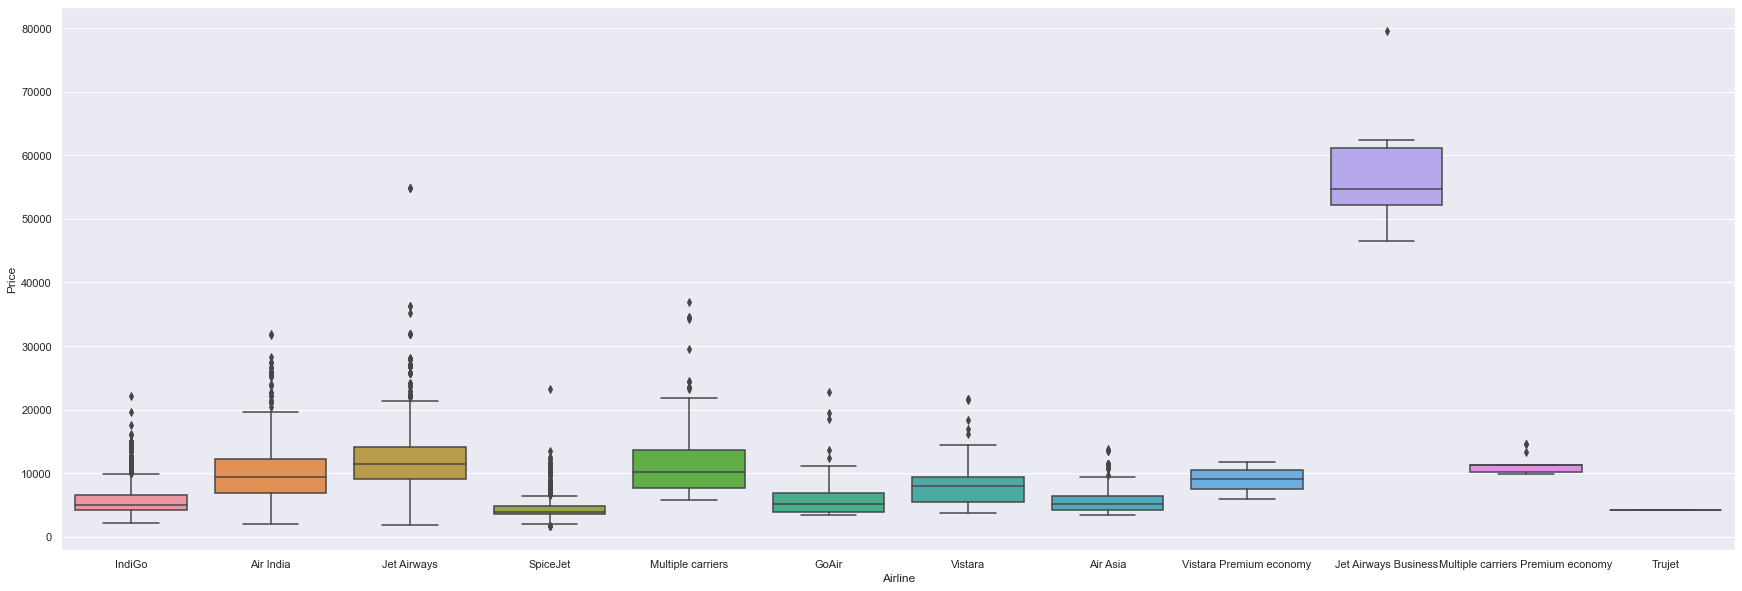

In [31]:
plt.figure(figsize=(30,10))
sns.boxplot(x='Airline',y='Price',data=df)

Observation-1 : Jet Airways airline is the costliest among all the given airlines. It's average fare is approx 11000
               and SpiceJet airline is the cheapest among all the given airlines


In [32]:
# From the above graph, this 'Jet Airways Business' airline details looks like outlier data. Lets check how many data
# points belong to this airline
df[df.Airline.str.contains('Jet Airways Business')]

,Airline,Source,Destination,Duration,Total_Stops,Price,weekday,Journey_Day,Journey_Month,Arrival_Hour,Dept_Hour
657,Jet Airways Business,Banglore,New Delhi,5,1,52229,4,1,3,10,5
2924,Jet Airways Business,Banglore,New Delhi,5,1,79512,4,1,3,11,5
5372,Jet Airways Business,Banglore,New Delhi,6,1,62427,4,1,3,12,5
7351,Jet Airways Business,Delhi,Cochin,8,2,46490,6,3,3,4,20
9715,Jet Airways Business,Delhi,Cochin,8,2,52285,2,6,3,4,20
10364,Jet Airways Business,Banglore,New Delhi,4,1,57209,4,1,3,14,9


In [33]:
# As there are very less number of data, we can remove these rows
df.drop(df[df.Airline=='Jet Airways Business'].index, inplace=True)

<AxesSubplot:xlabel='Airline', ylabel='Price'>

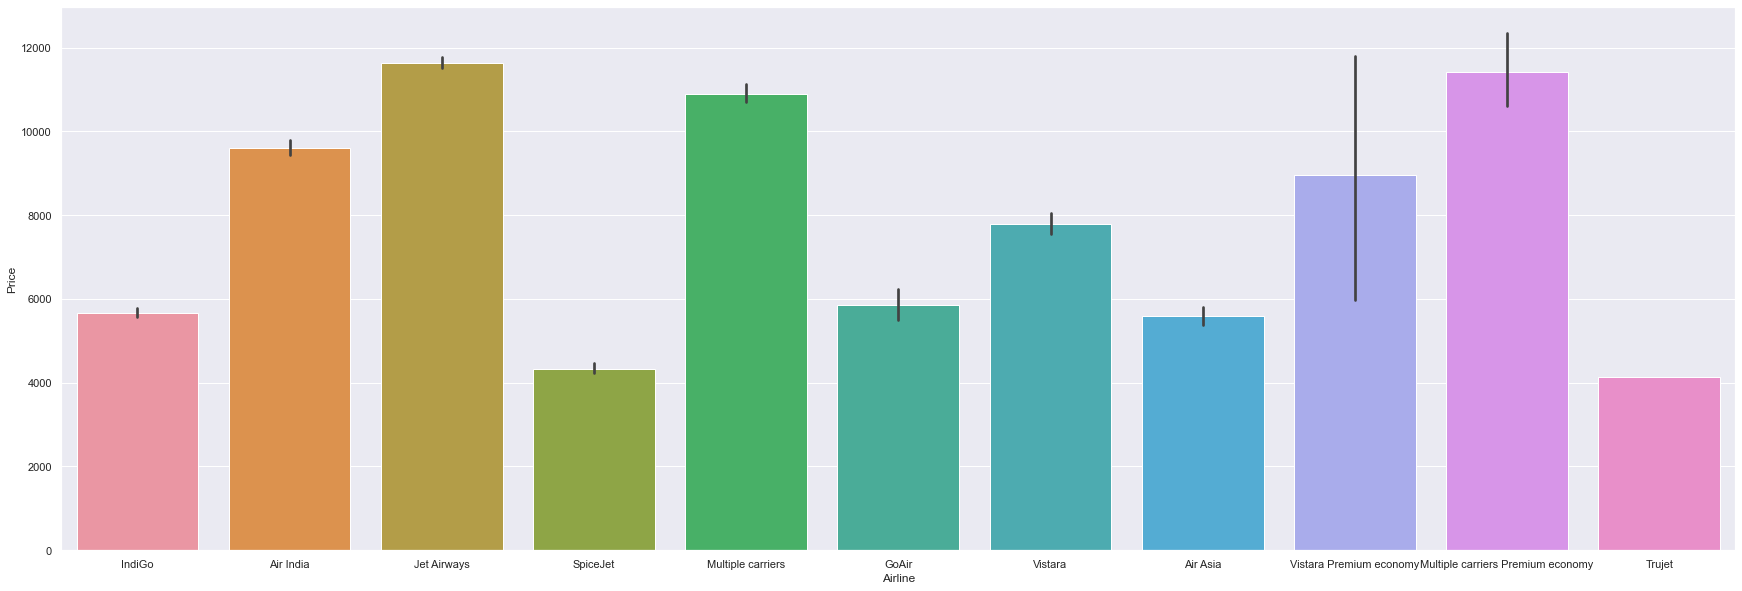

In [34]:
plt.figure(figsize=(30,10))
sns.barplot(x='Airline',y='Price',data=df)

Observation-2 : We can see here that Sunday and Friday see a more fare as compared to other days for most of the airlines

<AxesSubplot:>

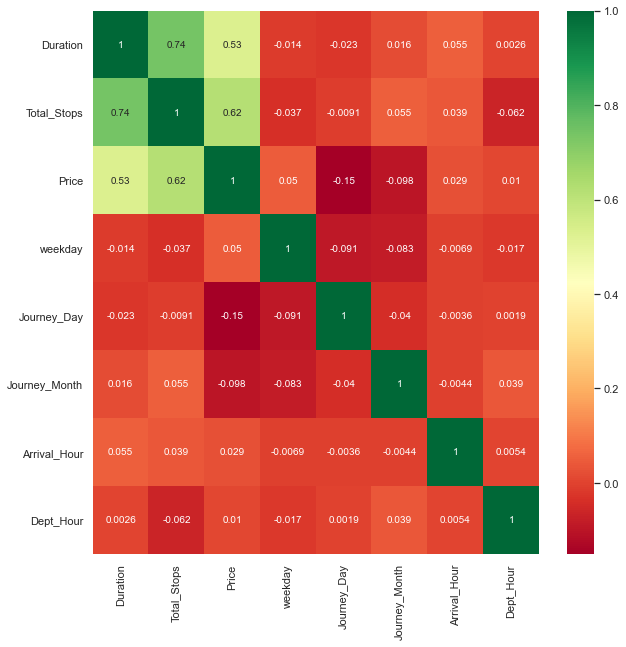

In [35]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True,cmap='RdYlGn')

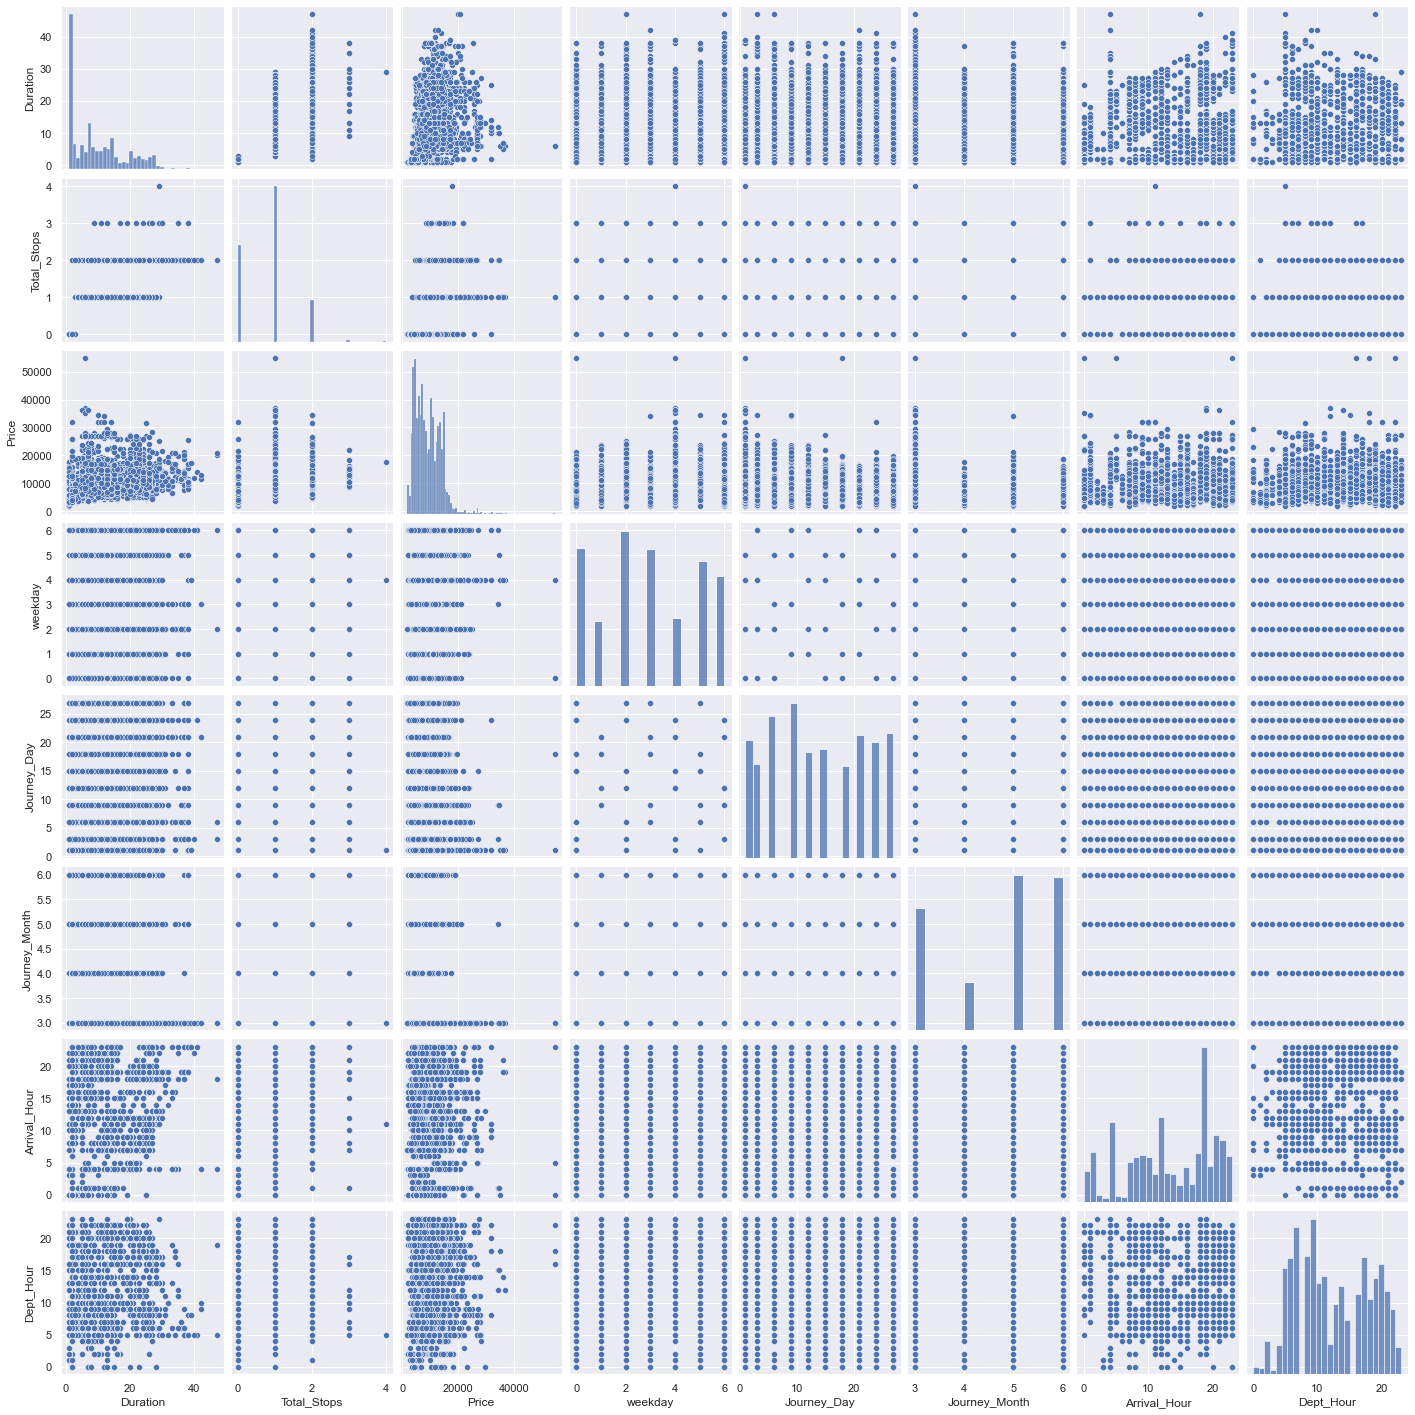

In [36]:
sns.pairplot(df)

### One-hot encoding for the categorical features

In [37]:
# Source
df.Source.value_counts()

Delhi       4535
Kolkata     2871
Banglore    2193
Mumbai       697
Chennai      381
Name: Source, dtype: int64

In [38]:
df = pd.get_dummies(df, columns=['Source'],drop_first=True)
df.head(2)

,Airline,Destination,Duration,Total_Stops,Price,weekday,Journey_Day,Journey_Month,Arrival_Hour,Dept_Hour,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,IndiGo,New Delhi,2,0,3897,6,24,3,1,22,0,0,0,0
1,Air India,Banglore,7,2,7662,2,1,5,13,5,0,0,1,0


In [39]:
# Destination
df.Destination.value_counts()

Cochin       4535
Banglore     2871
Delhi        1265
New Delhi     928
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [40]:
df = pd.get_dummies(df, columns=['Destination'],drop_first=True)
df.head(2)

,Airline,Duration,Total_Stops,Price,weekday,Journey_Day,Journey_Month,Arrival_Hour,Dept_Hour,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,IndiGo,2,0,3897,6,24,3,1,22,0,0,0,0,0,0,0,0,1
1,Air India,7,2,7662,2,1,5,13,5,0,0,1,0,0,0,0,0,0


In [41]:
# Dept_TimeOfDay
#df = pd.get_dummies(df, columns=['Dept_TimeOfDay'],drop_first=True)

In [42]:
# Arrival_TimeOfDay
#df = pd.get_dummies(df, columns=['Arrival_TimeOfDay'],drop_first=True)

In [43]:
# Airline
df = pd.get_dummies(df, columns=['Airline'],drop_first=True)

In [44]:
df.head(2)

,Duration,Total_Stops,Price,weekday,Journey_Day,Journey_Month,Arrival_Hour,Dept_Hour,Source_Chennai,Source_Delhi,...,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
0,2,0,3897,6,24,3,1,22,0,0,...,0,0,1,0,0,0,0,0,0,0
1,7,2,7662,2,1,5,13,5,0,0,...,1,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

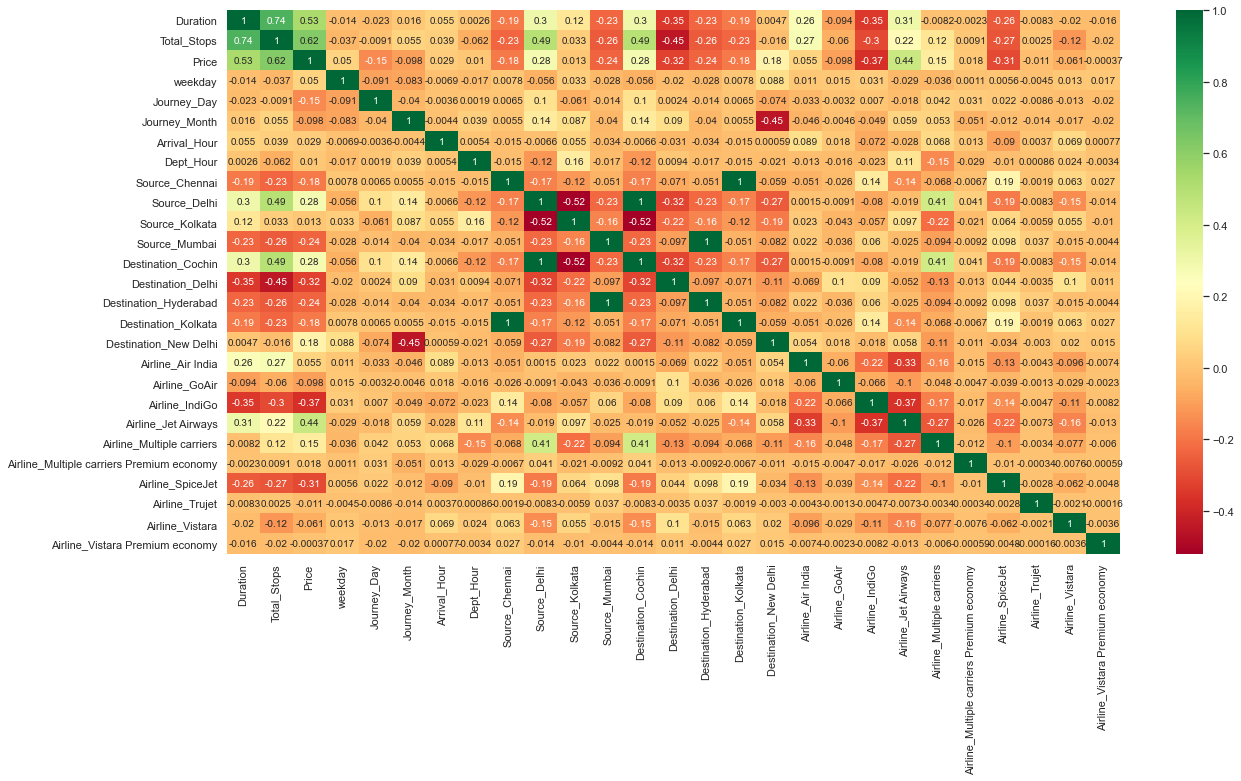

In [45]:
# Check the correlation now
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), annot=True,cmap='RdYlGn')

In [46]:
df.head()

,Duration,Total_Stops,Price,weekday,Journey_Day,Journey_Month,Arrival_Hour,Dept_Hour,Source_Chennai,Source_Delhi,...,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
0,2,0,3897,6,24,3,1,22,0,0,...,0,0,1,0,0,0,0,0,0,0
1,7,2,7662,2,1,5,13,5,0,0,...,1,0,0,0,0,0,0,0,0,0
2,19,2,13882,6,9,6,4,9,0,1,...,0,0,0,1,0,0,0,0,0,0
3,5,1,6218,6,12,5,23,18,0,0,...,0,0,1,0,0,0,0,0,0,0
4,4,1,13302,4,1,3,21,16,0,0,...,0,0,1,0,0,0,0,0,0,0


# Prepare data for training & model building

In [47]:
X = df.copy().drop(['Price'],axis=1)

Y = df.Price
X.shape

(10677, 26)

# Feature Selection - 
 -------- TODO -------

### Check important features - Just for reference (We are not dropping/selecting any feature based on this for now)
THIS SECTION NEEDS TO BE REVISITED - NOT WORKING CORRECTLY

In [67]:
# Check feature importance to identify the most important features
from sklearn.ensemble import ExtraTreesRegressor # As this is a regression problem
model=ExtraTreesRegressor()
model.fit(X,Y)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

[0.28142046 0.15104382 0.1203085  0.12439483 0.05678294 0.0495277
 0.04459005 0.03303251 0.02660125 0.02259023 0.01286027 0.01374363
 0.01695606 0.01199348 0.00826887 0.00618865 0.00633703 0.00616777
 0.00372998 0.00346198]


<AxesSubplot:>

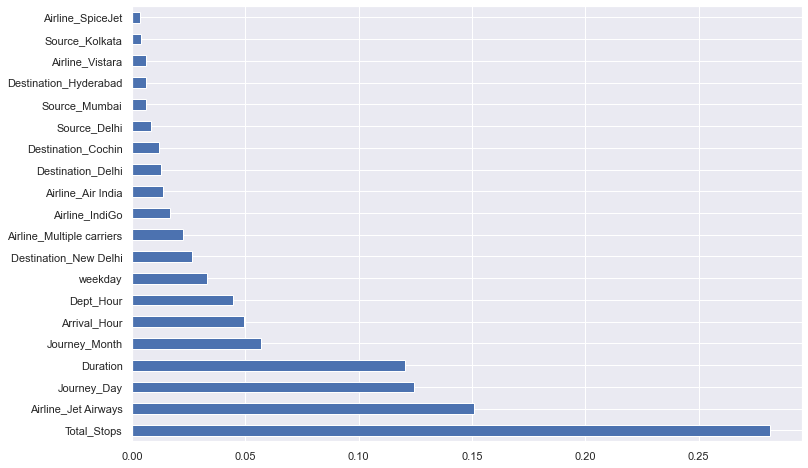

In [69]:
print(model.feature_importances_)

# Let's visualize this feature importances (Top 5 features)
plt.figure(figsize = (12,8))
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.nlargest(20).plot(kind='barh')

In [70]:
# Considering all columns
selected_columns = feature_importance.nlargest(20).index
selected_columns

Index(['Total_Stops', 'Airline_Jet Airways', 'Journey_Day', 'Duration',
       'Journey_Month', 'Arrival_Hour', 'Dept_Hour', 'weekday',
       'Destination_New Delhi', 'Airline_Multiple carriers', 'Airline_IndiGo',
       'Airline_Air India', 'Destination_Delhi', 'Destination_Cochin',
       'Source_Delhi', 'Source_Mumbai', 'Destination_Hyderabad',
       'Airline_Vistara', 'Source_Kolkata', 'Airline_SpiceJet'],
      dtype='object')

In [71]:
X = X[selected_columns]

In [72]:
X.shape

(10677, 20)

#### Training & Test set preparation

In [73]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
X_std = std_scaler.fit(X)
X_std = std_scaler.transform(X)

In [74]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_std,Y, test_size=0.3, random_state=20)

# Model Preparation & Training

In [75]:
from sklearn.ensemble import RandomForestRegressor
rnf_model=RandomForestRegressor()

### Hyper-parameter tuning

In [76]:
# No. of decision trees in the random forest
n_estimators = [int(x) for x in np.linspace(start=100, stop=1200,num=12)]
# No. of features to consider at every split
max_features = ['auto','sqrt']
# Maximum no. of levels in tree
max_depth = [int(x) for x in np.linspace(start=5, stop=50, num=5)]
# Minimum no. of samples required to split a node
min_samples_split = [2,5,10,15,100]
# Minimum no. of samples required at each leaf node
min_samples_leaf = [1,2,5,10]

In [77]:
# RandomizedSearchCV is little faster than GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

random_grid = {'n_estimators' : n_estimators,
               'max_features' : max_features,
               'max_depth' : max_depth,
               'min_samples_split' : min_samples_split,
               'min_samples_leaf' : min_samples_leaf}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 16, 27, 38, 50], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [78]:
# We will use the Random grid search to choose the best hyper parameter
# We will start with the base model and then use the parameter grid to choose the best parameter and get the best model
base_model = RandomForestRegressor()
model = RandomizedSearchCV(
                    estimator=base_model,
                    param_distributions=random_grid,
                    scoring='neg_mean_squared_error',
                    n_iter=10,
                    cv=5, # 5-fold cross validation
                    verbose=2, # To show the details of training process
                    random_state=42,
                    n_jobs=1) # n_job=1 --> All the cores of the CPU will be used

model.fit(X_train,Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   3.6s
[CV] END max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   3.7s
[CV] END max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   3.6s
[CV] END max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   3.7s
[CV] END max_depth=16, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   3.8s
[CV] END max_depth=27, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   4.7s
[CV] END max_depth=27, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   4.6s
[CV] END max_depth=27, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimator

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [79]:
model.best_params_

{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 38}

# Testing & Accuracy

In [80]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor()
reg_rf.fit(X_train, Y_train)

predictions = reg_rf.predict(X_test)
reg_rf.score(X_train,Y_train)

0.9470468057345232

/opt/anaconda3/envs/machine-learning-env/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


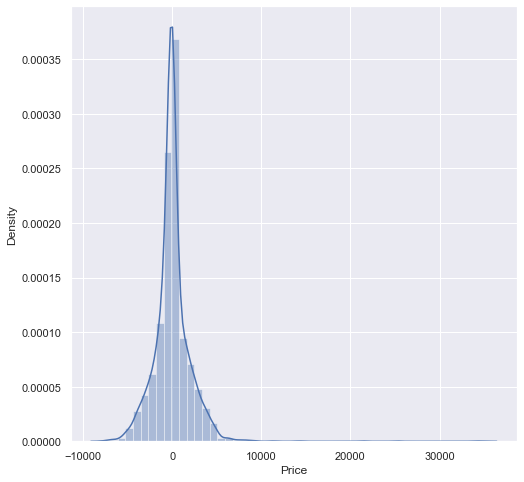

In [81]:
# 1. Compare the predictions with actual output by plotting their difference
plt.figure(figsize = (8,8))
sns.distplot(Y_test-predictions)
plt.show()

As the error (difference in values) is a normal distribution, so we can say our model is good 

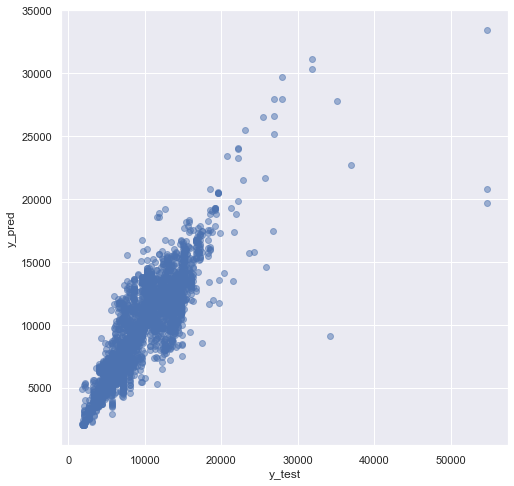

In [82]:
# 2. Plot the scatter plot
plt.figure(figsize = (8,8))
plt.scatter(Y_test, predictions, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

We can see the plotting is linear in nature which suggests a good prediction

In [83]:
from sklearn import metrics
metrics.r2_score(Y_test, predictions)

0.7735313923774323

In [84]:
# Save the model
file = open('flight-fare-prediction-model.pkl','wb')
pickle.dump(reg_rf, file)

In [86]:
# Model columns
X.columns

Index(['Total_Stops', 'Airline_Jet Airways', 'Journey_Day', 'Duration',
       'Journey_Month', 'Arrival_Hour', 'Dept_Hour', 'weekday',
       'Destination_New Delhi', 'Airline_Multiple carriers', 'Airline_IndiGo',
       'Airline_Air India', 'Destination_Delhi', 'Destination_Cochin',
       'Source_Delhi', 'Source_Mumbai', 'Destination_Hyderabad',
       'Airline_Vistara', 'Source_Kolkata', 'Airline_SpiceJet'],
      dtype='object')

In [87]:
X.head(2)

,Total_Stops,Airline_Jet Airways,Journey_Day,Duration,Journey_Month,Arrival_Hour,Dept_Hour,weekday,Destination_New Delhi,Airline_Multiple carriers,Airline_IndiGo,Airline_Air India,Destination_Delhi,Destination_Cochin,Source_Delhi,Source_Mumbai,Destination_Hyderabad,Airline_Vistara,Source_Kolkata,Airline_SpiceJet
0,0,0,24,2,3,1,22,6,1,0,1,0,0,0,0,0,0,0,0,0
1,2,0,1,7,5,13,5,2,0,0,0,1,0,0,0,0,0,0,1,0
